In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from raw_utils import demosaic_bilinear
from raw_utils import unpack_raw
#!pip install rawpy
import rawpy
from raw_utils import pack_raw
from dataset_navigation import get_image_paths
# from ipywidgets import interact, FloatSlider
from post_processor import PostProcessor, get_gray_world_constants

In [40]:

def load_image(file_path, normalize=True):
    raw = rawpy.imread(file_path).raw_image_visible
    white_point = np.array(rawpy.imread(file_path).camera_white_level_per_channel)
    black_point = np.array(rawpy.imread(file_path).black_level_per_channel)
    raw = pack_raw(raw)
    if normalize:
        raw = (raw - black_point) / (white_point - black_point)
    else:
        raw = raw.astype(np.float32)
    return raw


def kernel_blur(img, kernel):
    return cv2.filter2D(img, -1, kernel)


def sum_of_gaussians_kernel(sigma1, sigma2, ratio, downscale_factor=1.0):

    
    # I found the original values working on a scale of 
    sigma1 = sigma1 / downscale_factor
    sigma2 = sigma2 / downscale_factor
    ratio = ratio * (downscale_factor ** 2)

    kernel_size = int(np.ceil(6 * max(sigma1, sigma2))) + 1
    
    radius = kernel_size // 2
    x = np.arange(-radius, radius + 1)
    xx, yy = np.meshgrid(x, x, indexing='ij')

    g1 = np.exp(-(xx**2 + yy**2) / (2 * sigma1**2))
    g2 = np.exp(-(xx**2 + yy**2) / (2 * sigma2**2))
    g_sum = g1 + ratio * g2
    g_sum /= np.sum(g_sum)  # normalize to sum to 1

    # Create 1D kernel for visualization
    d1_kernel = g_sum[radius+1, :]  # take the middle row as 1D kernel
    return g_sum.astype(np.float32), d1_kernel.astype(np.float32)

def sum_of_gaussians_seperable_blur(image, sigma1=0.5, sigma2=40, ratio=0.000004375, downscale_factor=1.0):
    """
    Apply a separable sum of Gaussians blur to an image.
    """

    # k_size = int(np.ceil(10 * sigma1))
    # radius = k_size // 2
    # # then build the x-axis for each:
    # x = np.arange(-radius, radius + 1)   # e.g. [-3σ₁,…,0,…,+3σ₁]
    # 
    # Adjust sigmas and ratio for downscaling
    sigma1 = sigma1 / downscale_factor
    sigma2 = sigma2 / downscale_factor
    ratio = ratio * (downscale_factor ** 2)  # adjust ratio for downscaling

    radius = int(np.ceil(10*max(sigma1, sigma2)))
    x = np.arange(-radius, radius+1)

    g1_1d = np.exp(-x**2/(2*sigma1**2))
    g2_1d = np.exp(-x**2/(2*sigma2**2))
    
    # Sums are squared for normalization because we need to capture the 2d weighting
    S1 = g1_1d.sum()**2
    S2 = g2_1d.sum()**2
    C  = S1 + ratio * S2

    b1 = cv2.sepFilter2D(image, -1, g1_1d, g1_1d)
    b2 = cv2.sepFilter2D(image, -1, g2_1d, g2_1d)

    out = (b1 + ratio * b2) / C
    return np.clip(out, 0, 1)


def extend(image, limit=1, factor=10):
    """
    Extend values above a certain limit by a factor.
    """
    extended_image = image.copy()
    # Build a mask for pixels where any channel exceeds the limit
    pixel_mask = (extended_image >= limit).any(axis=-1)  # shape (H, W)
    # Expand mask to all channels and apply
    extended_image[pixel_mask] *= factor
    return extended_image


# def bloom_image(image, sigma1=0.5, sigma2=40, ratio=0.000004375, extend_factor=20, downscale_factor=1.0, method1=True):
def bloom_image(image, sigma1=0.5, sigma2=40, ratio=0.000004, extend_factor=20, downscale_factor=1.0, method1=True):

    extended = extend(image, limit=1, factor=extend_factor)
    if method1:
        kernel, _ = sum_of_gaussians_kernel(sigma1=sigma1, sigma2=sigma2, ratio=ratio, downscale_factor=downscale_factor)
        blurred_image = kernel_blur(extended, kernel)
    else:
        blurred_image = sum_of_gaussians_seperable_blur(extended, sigma1=sigma1, sigma2=sigma2, ratio=ratio, downscale_factor=downscale_factor)
    clipped_image = np.clip(blurred_image, 0, 1)
    return clipped_image




In [5]:
paths = get_image_paths()
long_exp_paths = paths["long_exp"]
filtered_exp_paths = paths["filter_long_exp"]
# idx = 22 # Handbag
# idx = 0 # House
idx = 16 # Slide
idx = 198 # Lamp?
image_diff = load_image(filtered_exp_paths[idx])
image_org = load_image(long_exp_paths[idx])
# Downsample the images
downsample_factor = 2

image_diff = cv2.resize(image_diff, (image_diff.shape[1] // downsample_factor, image_diff.shape[0] // downsample_factor), interpolation=cv2.INTER_LINEAR)
image_org = cv2.resize(image_org, (image_org.shape[1] // downsample_factor, image_org.shape[0] // downsample_factor), interpolation=cv2.INTER_LINEAR)
image_diff = image_diff / image_diff.max()
image_org = image_org / image_org.max()

pp = PostProcessor(get_gray_world_constants(image_diff), gamma=2.2)
image_org_rgb = pp.postprocess(image_org)
image_diff_rgb = pp.postprocess(image_diff, get_gray_world_constants(image_diff))


MSE between original and method 1: 0.002340
MSE between original and method 2: 0.002340
MSE between method 1 and method 2: 0.000000


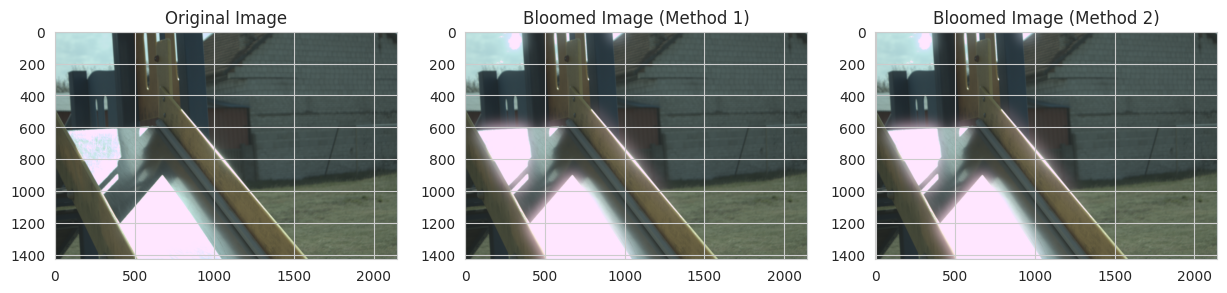

In [34]:

blurred1 = bloom_image(image_org, extend_factor=20, downscale_factor=downsample_factor, method1=True)
blurred2 = bloom_image(image_org, extend_factor=20, downscale_factor=downsample_factor, method1=False)
blurred1 = pp.postprocess(blurred1)
blurred2 = pp.postprocess(blurred2)

# Show MSE difference matrix between the three photos
mse1 = np.mean((image_org_rgb - blurred1) ** 2)
mse2 = np.mean((image_org_rgb - blurred2) ** 2)
mse3 = np.mean((blurred1 - blurred2) ** 2)

print(f'MSE between original and method 1: {mse1:.6f}')
print(f'MSE between original and method 2: {mse2:.6f}')
print(f'MSE between method 1 and method 2: {mse3:.6f}')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_org_rgb)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(blurred1)
plt.title('Bloomed Image (Method 1)')
plt.subplot(1, 3, 3)
plt.imshow(blurred2)
plt.title('Bloomed Image (Method 2)')
plt.show()



In [35]:
import cv2
import numpy as np
def nothing(x): pass

cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Image', 1500, 400)
cv2.createTrackbar('Bloom Intensity', 'Image', 100, 100, nothing)

last_bloom_intensity = -1

# bloom_intensity = 50
# bloomed_image = bloom_image( image_org,
#                              extend_factor=bloom_intensity, downscale_factor=downsample_factor
#                              )
# pp = PostProcessor(get_gray_world_constants(bloomed_image), gamma=2.2)
# bloomed_image_rgb = pp.postprocess(bloomed_image)
# plt.imshow(bloomed_image_rgb)

while True:
    bloom_intensity = cv2.getTrackbarPos('Bloom Intensity', 'Image')
    # threshold = cv2.getTrackbarPos('Threshold', 'Image') / 100.0

    if bloom_intensity != last_bloom_intensity:
        # Update only if something changed
        bloomed_image = bloom_image( image_org,
            extend_factor=bloom_intensity, downscale_factor=downsample_factor
        )
        pp = PostProcessor(get_gray_world_constants(bloomed_image), gamma=2.2)
        bloomed_image_rgb = pp.postprocess(bloomed_image)

        montage = np.hstack((image_org_rgb, bloomed_image_rgb, image_diff_rgb))
        cv2.imshow('Image', montage)

        last_bloom_intensity = bloom_intensity
        # last_threshold = threshold

    # Press 'Esc' to exit !!!
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()

KeyboardInterrupt: 

Image shape: (714, 1072, 4)
Input shape: torch.Size([1, 4, 714, 1072])
Blurred shape: (714, 1072, 4)
MSE between method 1 and net: 0.16002408015414282


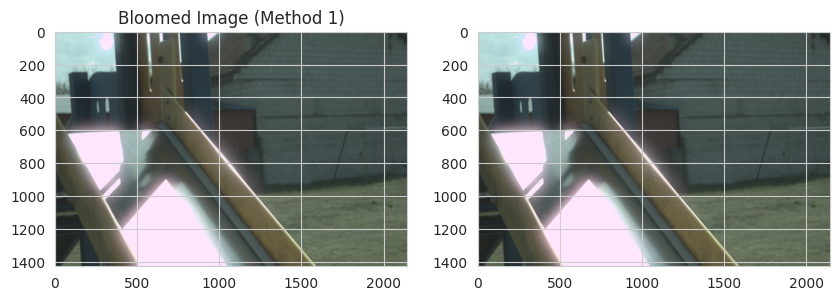

In [26]:
# Test if our nn module for the blur is the same as our implementation here
from extension_blur_net import FixedSumOfGaussians
blurred1 = bloom_image(image_org, extend_factor=20, downscale_factor=downsample_factor, method1=True)
blurred1 = pp.postprocess(blurred1)
print("Image shape:", image_org.shape)
blur_net = FixedSumOfGaussians(sigma1=0.5, sigma2=40, ratio=0.000004375, downscale_factor=downsample_factor, channels=4)
torch_image = torch.tensor(extend(image_org, factor=20)).permute(2, 0, 1).unsqueeze(0).float()
print("Input shape:", torch_image.shape)
blurred_net = blur_net(torch_image)
blurred_net = blurred_net.detach().cpu().numpy()
blurred_net = blurred_net.squeeze().transpose(1, 2, 0)
print("Blurred shape:", blurred_net.shape)
blurred_net = np.clip(blurred_net, 0, 1)
blurred_net = pp.postprocess(blurred_net)
print("MSE between method 1 and net:", np.max(np.abs(blurred1 - blurred_net)))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blurred1)
plt.title('Bloomed Image (Method 1)')
plt.subplot(1, 2, 2)
plt.imshow(blurred_net)


In [6]:
from dataset_navigation import get_image_paths

paths = get_image_paths()
print(len(paths["long_exp"]))

237


In [21]:
from tqdm import tqdm
import numpy as np
# Test the bloom image on all images for different ratios
ids = [0, 16, 22, 198]
extend_factor = [5, 30, 45, 40]
ratio_start = 0.000001
ratio_end = 0.00005
ratio_step = (ratio_end - ratio_start)/10
ratios= np.arange(ratio_start, ratio_end, ratio_step)
downsample_factor = 6

combined_image = np.zeros((0, 0, 3))
# Show the images on a grid, with each row containing the original image the bloomed image for each id. Row for each ratio
# preload the filtered images
filtered_postprocessed = []

for idx in ids:
    image_diff = load_image(paths["filter_long_exp"][idx])
    image_diff = cv2.resize(image_diff, (image_diff.shape[1] // downsample_factor, image_diff.shape[0] // downsample_factor), interpolation=cv2.INTER_LINEAR)
    image_diff = image_diff / image_diff.max()
    pp = PostProcessor(get_gray_world_constants(image_diff), gamma=2.2)
    image_diff_rgb = pp.postprocess(image_diff)
    filtered_postprocessed.append(image_diff_rgb)

for ratio in tqdm(ratios):
    row = []
    for i, (idx, ef) in enumerate(zip(ids, extend_factor)):
        image_org = load_image(paths["long_exp"][idx])
        # Downsample the images
        image_org = cv2.resize(image_org, (image_org.shape[1] // downsample_factor, image_org.shape[0] // downsample_factor), interpolation=cv2.INTER_LINEAR)
        image_org = image_org / image_org.max()
        bloomed_image = bloom_image(image_org, extend_factor=ef, downscale_factor=downsample_factor, method1=True, ratio=ratio)

        bloomed_image_rgb = pp.postprocess(bloomed_image) # Shape (H, W, 3)
        row.append(filtered_postprocessed[i])  # Append the filtered image
        row.append(bloomed_image_rgb)
    combined_row = np.hstack(row)
    if combined_image.shape[0] == 0:
        combined_image = combined_row
    else:
        combined_image = np.vstack((combined_image, combined_row))



100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


In [20]:
# View image with cv2
cv2.namedWindow('Bloomed Images', cv2.WINDOW_NORMAL)
cv2.imshow('Bloomed Images', combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

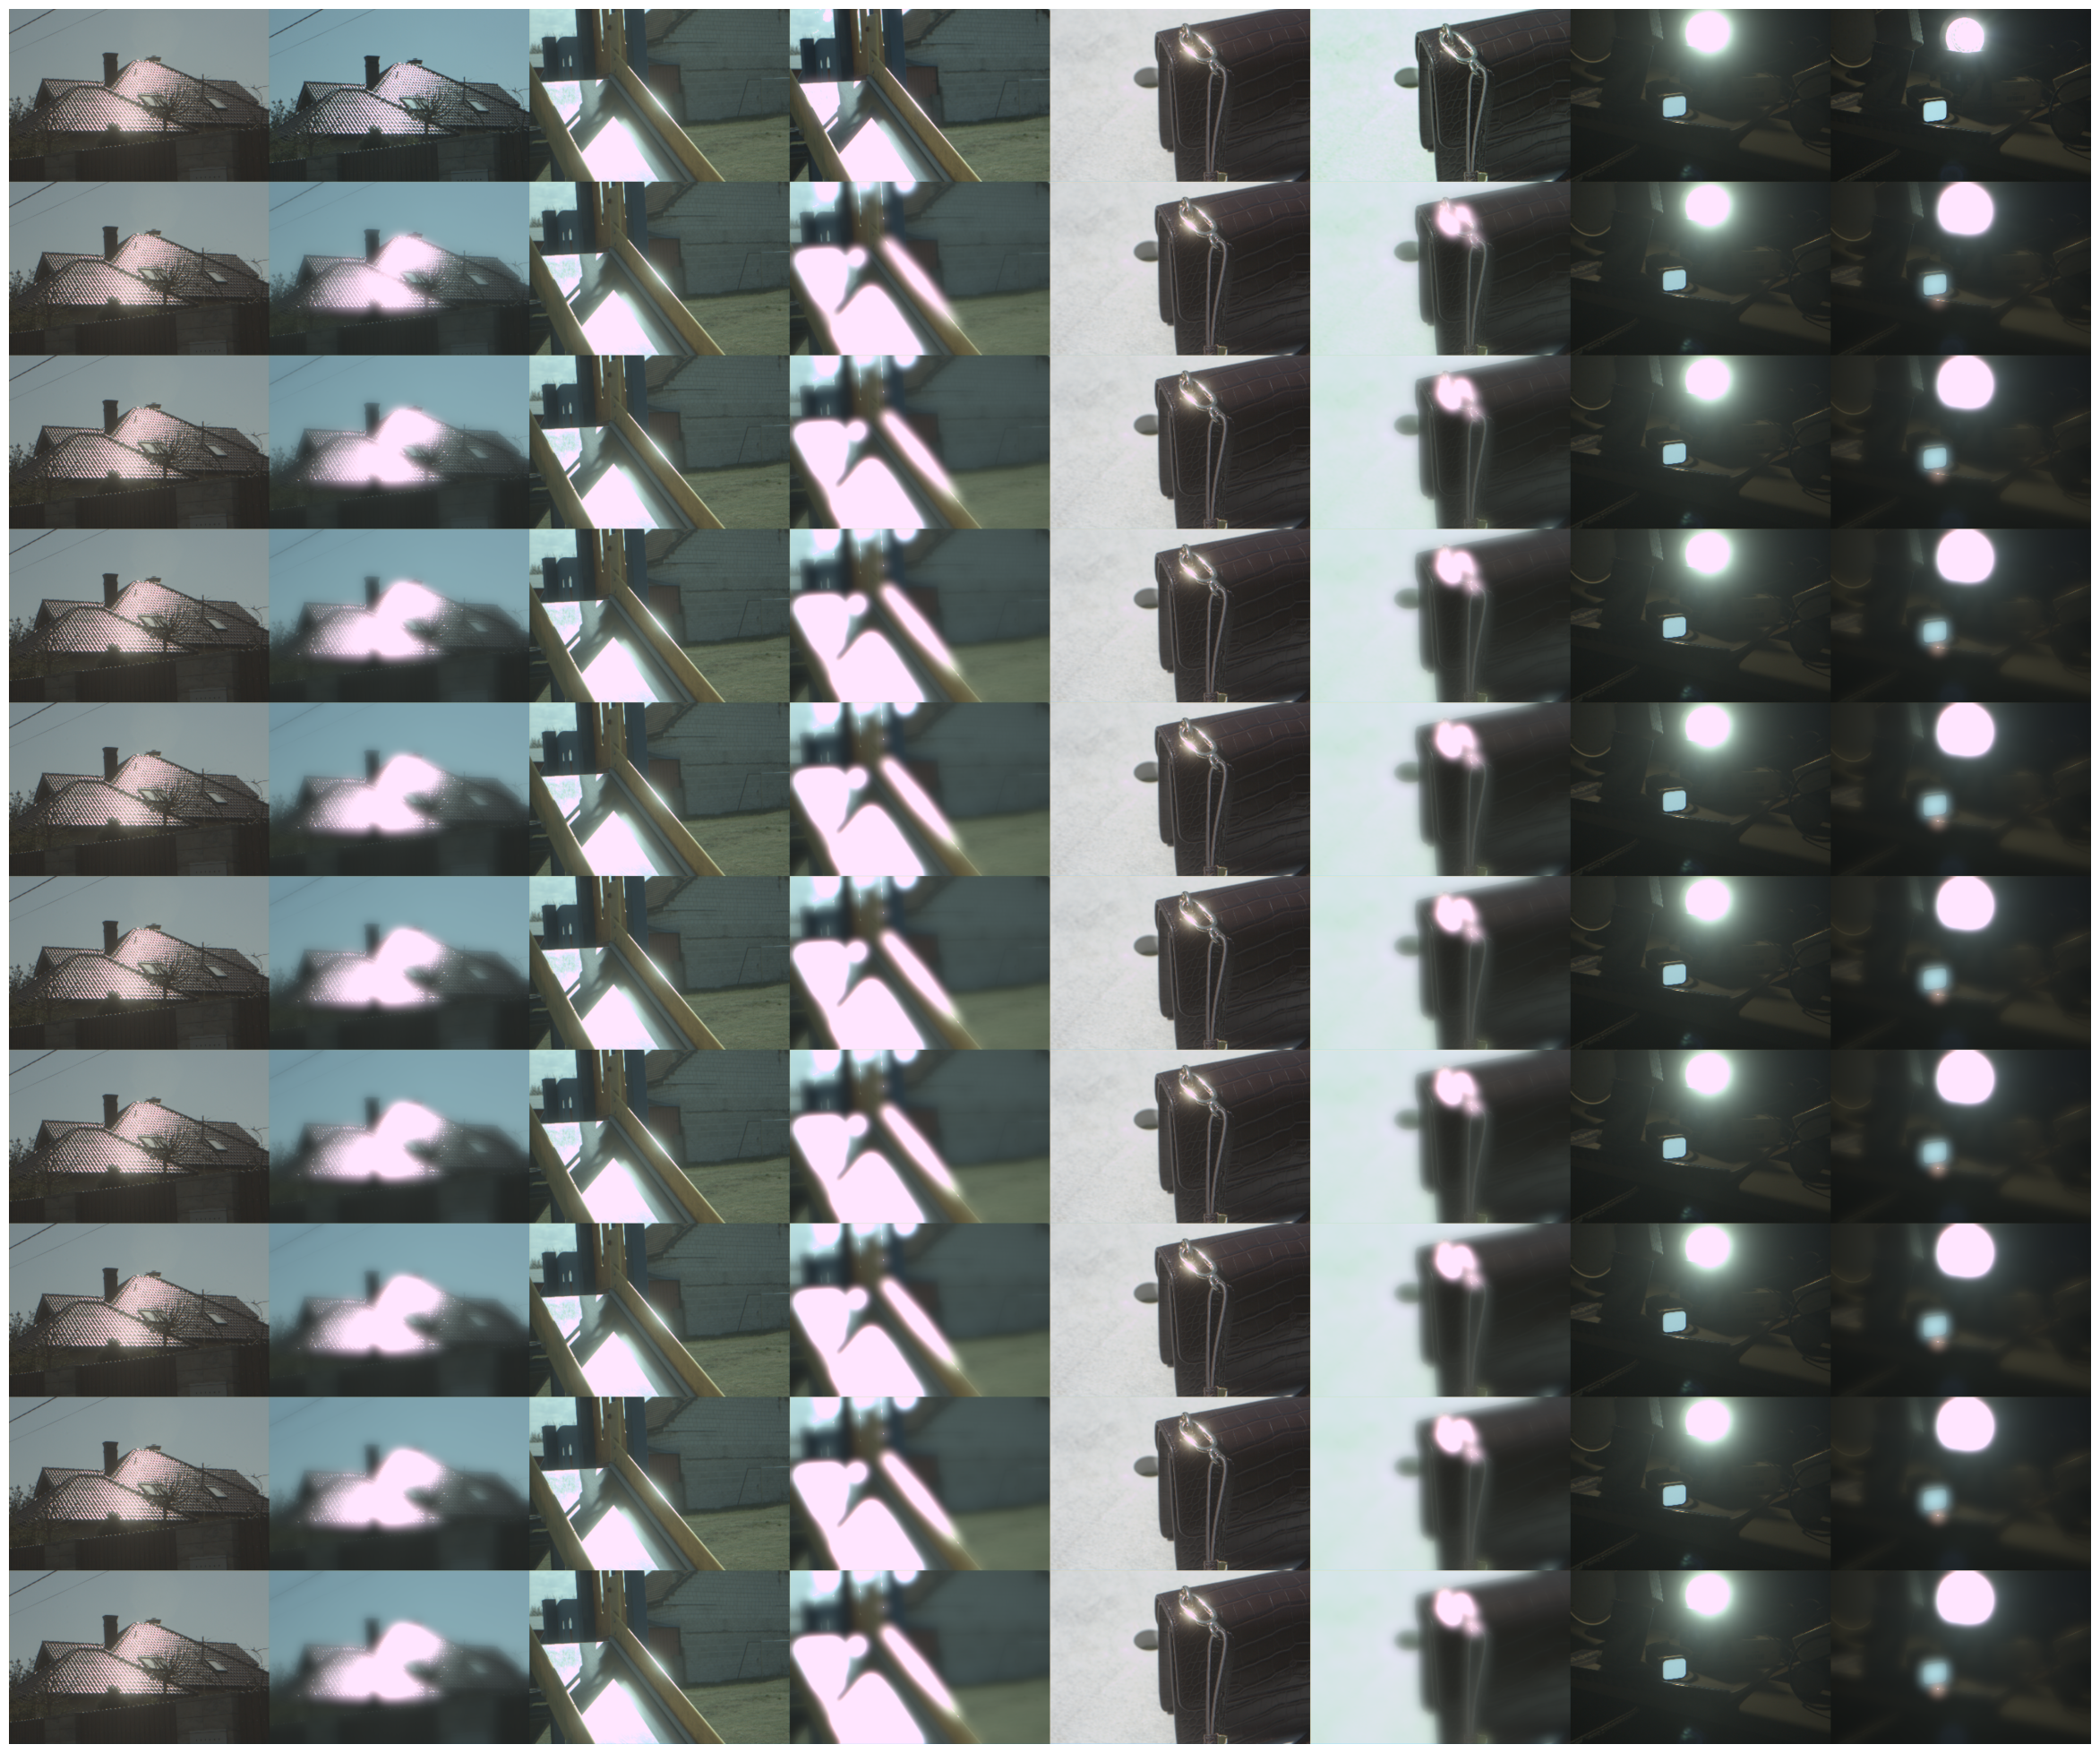

In [18]:
plt.figure(figsize=(30, 30))
plt.imshow(combined_image)
plt.axis('off')
plt.grid(False)
plt.show()

In [48]:
print(combined_image.shape)

(1140, 6864, 3)


In [ ]:
# Side by side comparison of the diffused and bloomed image for the lamp with a configurable ratio

# Calculate bloomed images for the lamp image with different ratios

In [ ]:
# displayed with plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)


(241,)
241
120
-120 120
(241,)


/tmp/ipykernel_544478/3597485428.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


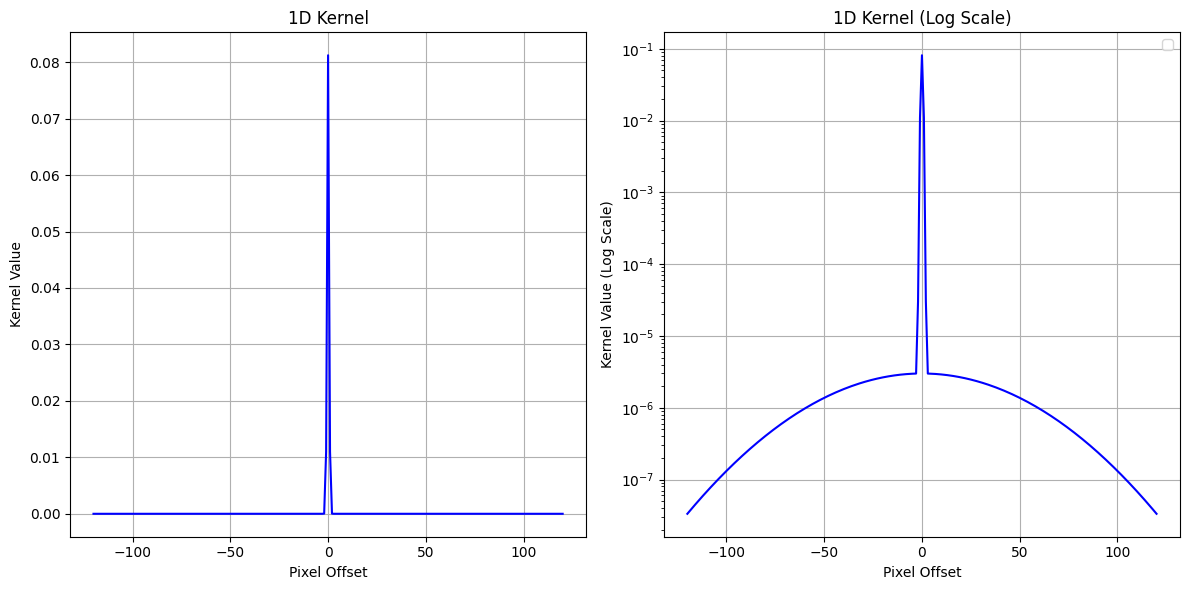

In [41]:
# Get the 1D kernel 
sigma1 = 0.5
sigma2 = 40
ratio = 0.000005
kernel, d1_kernel = sum_of_gaussians_kernel(sigma1=sigma1, sigma2=sigma2, ratio=ratio, downscale_factor=1)
print(d1_kernel.shape)
kernel_size = int(np.ceil(6 * max(sigma1, sigma2))) + 1
print(kernel_size)
print(kernel_size // 2)
r = kernel_size // 2
x = np.arange(-r, r + 1)
print(x[0], x[-1])
print(x.shape)
# Plot on two plots, one linear and one log scale
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, d1_kernel, label='1D Kernel', color='blue')
plt.title('1D Kernel')
plt.xlabel('Pixel Offset')
plt.ylabel('Kernel Value')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x, d1_kernel, color='blue')
plt.title('1D Kernel (Log Scale)')
plt.xlabel('Pixel Offset')
plt.ylabel('Kernel Value (Log Scale)')
plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


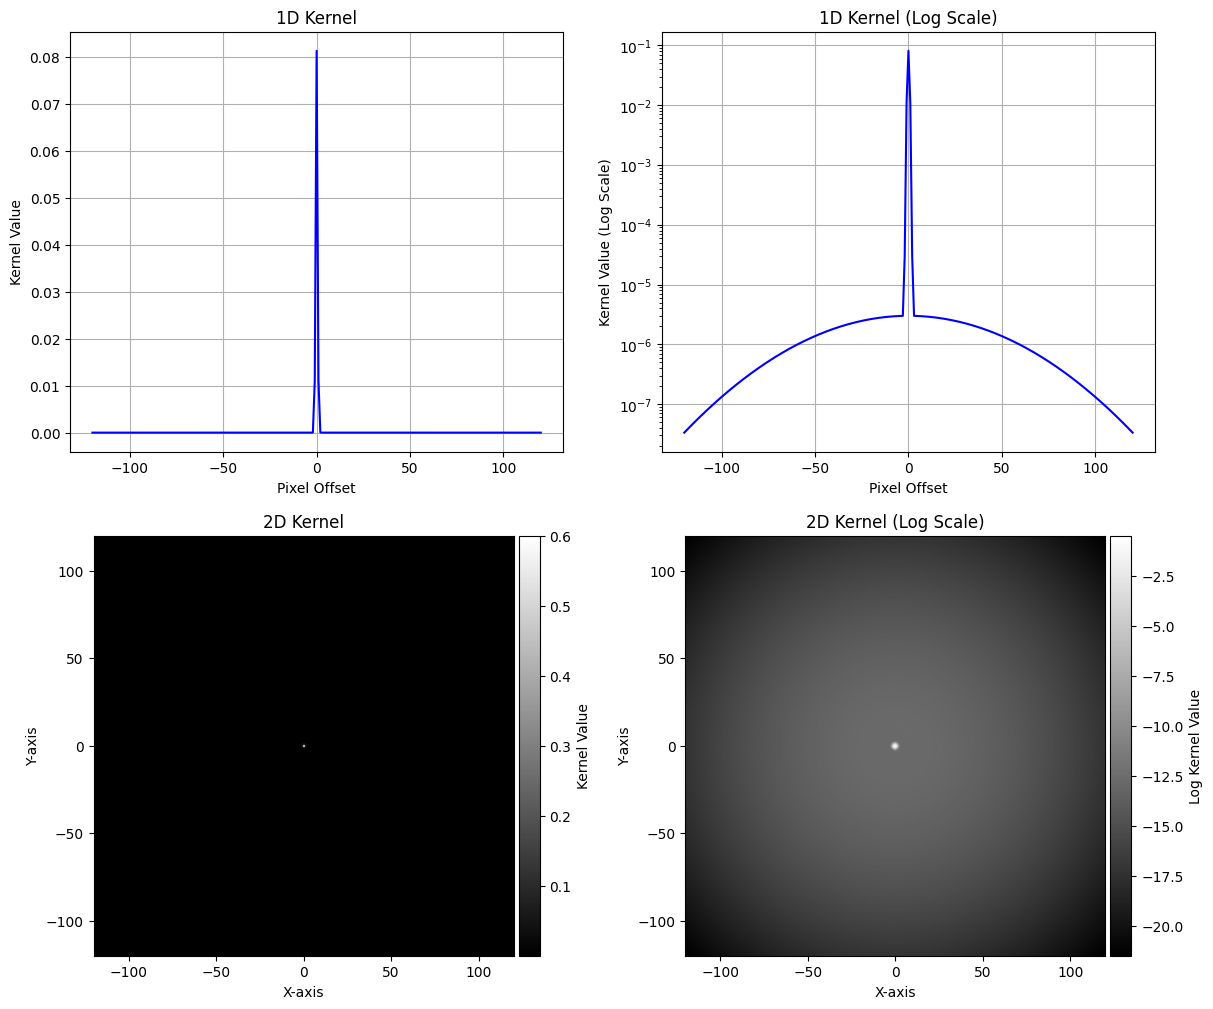

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# 1D Kernel - Linear
axs[0, 0].plot(x, d1_kernel, label='1D Kernel', color='blue')
axs[0, 0].set_title('1D Kernel')
axs[0, 0].set_xlabel('Pixel Offset')
axs[0, 0].set_ylabel('Kernel Value')
axs[0, 0].grid()

# 1D Kernel - Log
axs[0, 1].plot(x, d1_kernel, color='blue')
axs[0, 1].set_title('1D Kernel (Log Scale)')
axs[0, 1].set_xlabel('Pixel Offset')
axs[0, 1].set_ylabel('Kernel Value (Log Scale)')
axs[0, 1].set_yscale('log')
axs[0, 1].grid()

# 2D Kernel - Linear (with colorbar)
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[1, 0].imshow(kernel, cmap='gray', extent=(-r, r, -r, r))
axs[1, 0].set_title('2D Kernel')
axs[1, 0].set_xlabel('X-axis')
axs[1, 0].set_ylabel('Y-axis')
axs[1, 0].axis('equal')
axs[1, 0].grid(False)
fig.colorbar(im, cax=cax, label='Kernel Value')

# 2D Kernel - Log (with colorbar)
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[1, 1].imshow(np.log(kernel + 1e-10), cmap='gray', extent=(-r, r, -r, r))
axs[1, 1].set_title('2D Kernel (Log Scale)')
axs[1, 1].set_xlabel('X-axis')
axs[1, 1].set_ylabel('Y-axis')
axs[1, 1].axis('equal')
axs[1, 1].grid(False)
fig.colorbar(im, cax=cax, label='Log Kernel Value')




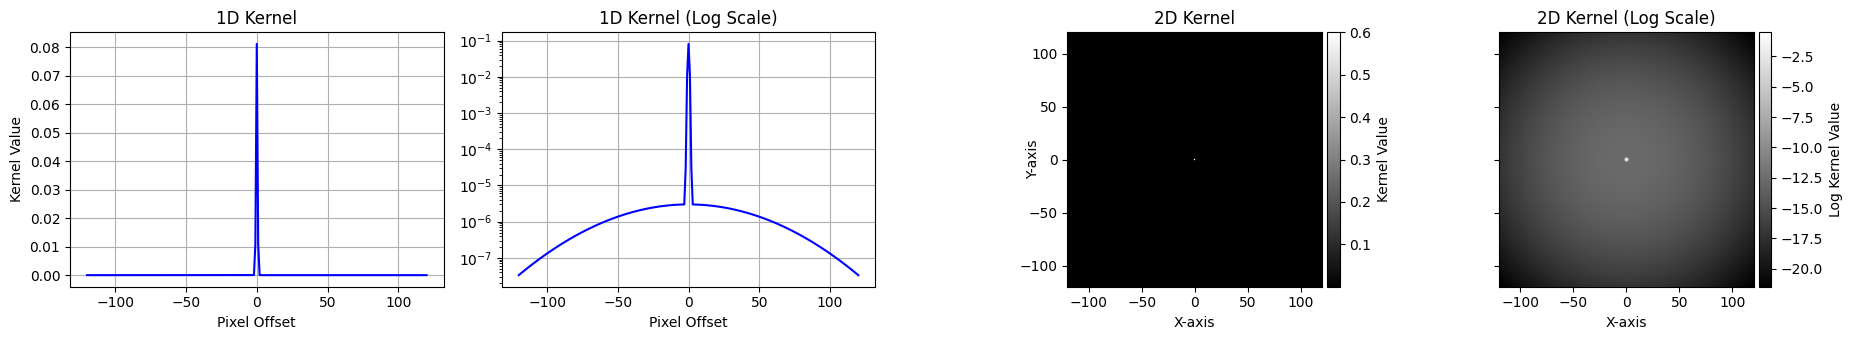

In [103]:
# Same plot but all figures in one row
fig, axs = plt.subplots(1, 4, figsize=(18, 3.5))
plt.subplots_adjust(wspace=-0.0)
# 1D Kernel - Linear
axs[0].plot(x, d1_kernel, label='1D Kernel', color='blue')
axs[0].set_title('1D Kernel')
axs[0].set_xlabel('Pixel Offset')
axs[0].set_ylabel('Kernel Value')
axs[0].grid()
# 1D Kernel - Log
axs[1].plot(x, d1_kernel, color='blue')
axs[1].set_title('1D Kernel (Log Scale)')
axs[1].set_xlabel('Pixel Offset')
axs[1].set_yscale('log')
axs[1].grid()
# 2D Kernel - Linear (with colorbar)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[2].imshow(kernel, cmap='gray', extent=(-r, r, -r, r))
axs[2].set_title('2D Kernel')
axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Y-axis')
axs[2].yaxis.labelpad = -15  # or try -2 for even closer

axs[2].axis('equal')
axs[2].grid(False)
fig.colorbar(im, cax=cax, label='Kernel Value')
# 2D Kernel - Log (with colorbar)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[3].imshow(np.log(kernel + 1e-10), cmap='gray', extent=(-r, r, -r, r))
axs[3].set_title('2D Kernel (Log Scale)')
axs[3].set_xlabel('X-axis')
# axs[3].set_ylabel('Y-axis')
# axs[3].yaxis.labelpad = -15
# axs[3].axis('equal')
axs[3].grid(False)
axs[3].tick_params(labelleft=False)
axs[3].set_ylabel("")
fig.colorbar(im, cax=cax, label='Log Kernel Value')
plt.tight_layout()

# Shrink the main axes (for 2D kernels) slightly to reduce whitespace
axs[2].set_position([axs[2].get_position().x0,
                     axs[2].get_position().y0,
                     0.30,  # width: reduce from default ~0.21
                     axs[2].get_position().height])

axs[3].set_position([axs[3].get_position().x0,
                     axs[3].get_position().y0,
                     0.30,
                     axs[3].get_position().height])
plt.show()


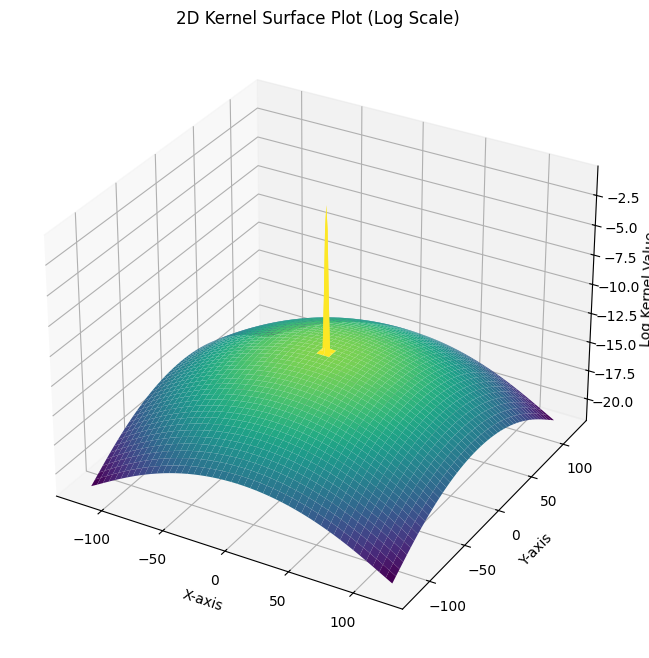

In [79]:
# Show the 2d kernel as a 3D surface plot on log scale
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, x)
ax.plot_surface(X, Y, np.log(kernel + 1e-10), cmap='viridis', edgecolor='none')
ax.set_title('2D Kernel Surface Plot (Log Scale)')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Log Kernel Value')
plt.show()

